In [1]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
import pickle
import scienceplots
plt.style.use(['science', 'grid', 'bright'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})

In [2]:
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/10h/data_0003.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

df_hits = load_dataset(file_path)
og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 4.56% of all events


In [3]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False, sampling = 10, angle_sampling = 240):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    chi_squares = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0], leave = True, desc = 'events'):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)
            
        if track.reduced_chi2() is not None:
            chi_squares.append(track.reduced_chi2())

    return tracks, chi_squares
    

In [4]:
# getting tracks
tracks, chi_squares = create_tracks(df_hits.iloc[15000:16000])
total_events = len(tracks)
# with open('hough_parameters_tracks.pkl', 'wb') as outp:
    # pickle.dump(tracks, outp, pickle.HIGHEST_PROTOCOL)
with open('hough_parameters_tracks.pkl', 'rb') as inp:
    tracks = pickle.load(inp)

events: 100%|██████████| 1000/1000 [00:14<00:00, 69.65it/s]


from timeit import default_timer as timer
samplings = np.linspace(1, 50, 20)
ratios_good_tracks = []
timing = []
for s in tqdm(samplings, desc = 'sampling'):
    start = timer()
    for t in tqdm(tracks, desc = 'tracks', leave = False):
        t.find_track(int(s), 100)
    end = timer()
    ratios_good_tracks.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)
    timing.append((end - start) * 1000/total_events)
    
samplings2 = np.linspace(1, 50, 20)
ratios_good_tracks2 = []
timing2 = []
for s in tqdm(samplings2, desc='sampling2'):
    start = timer()
    for t in tqdm(tracks, desc = 'tracks', leave = False):
        t.find_track(int(s), 200)
    end = timer()
    ratios_good_tracks2.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)
    timing2.append((end-start) * 1000/total_events)
    
samplings3 = np.linspace(50, 250, 40)
ratios_good_tracks3 = []
timing3 = []
for s in tqdm(samplings3, desc='sampling3'):
    start = timer()
    for t in tqdm(tracks, desc = 'tracks', leave = False):
        t.find_track(10, int(s))
    end = timer()
    ratios_good_tracks3.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)
    timing3.append((end - start) * 1000 / total_events)

samplings4 = np.linspace(50, 250, 40)
ratios_good_tracks4 = []
timing4 = []
for s in tqdm(samplings4, desc='sampling4'):
    start = timer()
    for t in tqdm(tracks, desc = 'tracks', leave = False):
        t.find_track(20, int(s))
    end = timer()
    ratios_good_tracks4.append(len([t for t in tracks if t.is_good_2D_fit()]) / total_events)
    timing4.append((end - start) * 1000 / total_events)
    
with open('parameters1.pkl', 'wb') as outp:
    pickle.dump([samplings, ratios_good_tracks, timing], outp, pickle.HIGHEST_PROTOCOL)
with open('parameters2.pkl', 'wb') as outp:
    pickle.dump([samplings2, ratios_good_tracks2, timing2], outp, pickle.HIGHEST_PROTOCOL)
with open('parameters3.pkl', 'wb') as outp:
    pickle.dump([samplings3, ratios_good_tracks3, timing3], outp, pickle.HIGHEST_PROTOCOL)
with open('parameters4.pkl', 'wb') as outp:
    pickle.dump([samplings4, ratios_good_tracks4, timing4], outp, pickle.HIGHEST_PROTOCOL)



In [10]:
from timeit import default_timer as timer
cell_sampling = [1, 5, 10, 15, 20]
angle_sampling = [50, 100, 150, 200, 250]

ratios_for_cells = []
timings_for_cells = []
for_cells_angle_sampling = np.linspace(10, 250, 60, dtype = int)
for cs in tqdm(cell_sampling, desc = 'for cell sampling', position=0, leave = True):
    ratios = []
    timings = []
    for a in tqdm(for_cells_angle_sampling, desc = 'angle sampling', position=1, leave = False):
        start = timer()
        for t in tracks: #tqdm(tracks, desc = 'tracks', leave = False, position=2):
            t.find_track(cs, a)
        end = timer()
        ratios.append(len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events)
        timings.append((end - start) * 1000 / total_events)
    ratios_for_cells.append(ratios)
    timings_for_cells.append(timings)
    
ratios_for_angles = []
# timings_for_angles = []
# for_angles_cell_sampling = np.linspace(1, 20, 20, dtype = int)
# for a in tqdm(angle_sampling, desc = 'for angle sampling', position=0, leave = True):
#     ratios = []
#     timings = []
#     for cs in tqdm(for_angles_cell_sampling, desc = 'cell sampling', position=1, leave = False):
#         start = timer()
#         for t in tracks: #tqdm(tracks, desc = 'tracks', leave = False, position=2):
#             t.find_track(cs, a)
#         end = timer()
#         ratios.append(len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events)
#         timings.append((end - start) * 1000 / total_events)
#     ratios_for_angles.append(ratios)
#     timings_for_angles.append(timings)
    
with open('hough_parameters_for_cells2.pkl', 'wb') as outp:
    pickle.dump([cell_sampling, ratios_for_cells, timings_for_cells, for_cells_angle_sampling], outp, pickle.HIGHEST_PROTOCOL)
with open('hough_parameters_for_angles2.pkl', 'wb') as outp:
    pickle.dump([angle_sampling, ratios_for_angles, timings_for_angles, for_angles_cell_sampling], outp, pickle.HIGHEST_PROTOCOL)
    
with open('hough_parameters_for_angles.pkl', 'rb') as inp:
    [angle_sampling, ratios_for_angles, timings_for_angles, for_angles_cell_sampling] = pickle.load(inp)

for cell sampling: 100%|██████████| 5/5 [1:41:44<00:00, 1220.92s/it]


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 3)
axs[0].plot(samplings, ratios_good_tracks, 'x-', label = 'angle sampling = 100')
axs[0].plot(samplings2, ratios_good_tracks2, '+-', label = 'angle sampling = 200')
axs[1].plot(samplings3, ratios_good_tracks3, 'x-', label = 'cell sampling = 10')
axs[1].plot(samplings4, ratios_good_tracks4, '+-', label='cell sampling = 20')
axs[0].set(xlabel='sampling', ylabel='ratio good tracks')
axs[0].grid(which = 'major', alpha = 0.5)
axs[0].grid(which = 'minor', alpha = 0.2)
axs[0].legend()
axs[1].set(xlabel='angle', ylabel='ratio good tracks')
axs[1].grid(which='major', alpha=0.5)
axs[1].grid(which='minor', alpha=0.2)
axs[1].legend()

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 3)
axs[0].plot(samplings, timing, 'x-', label='angle sampling = 100')
axs[0].plot(samplings2, timing2, '+-', label='angle sampling = 200')
axs[1].plot(samplings3, timing3, 'x-', label='cell sampling = 10')
axs[1].plot(samplings4, timing4, '+-', label='cell sampling = 20')
axs[0].set(xlabel='sampling', ylabel='mean time per track')
axs[0].grid(which='major', alpha=0.5)
axs[0].grid(which='minor', alpha=0.2)
axs[0].legend()
axs[1].set(xlabel='angle', ylabel='mean time per track')
axs[1].grid(which='major', alpha=0.5)
axs[1].grid(which='minor', alpha=0.2)
axs[1].legend()


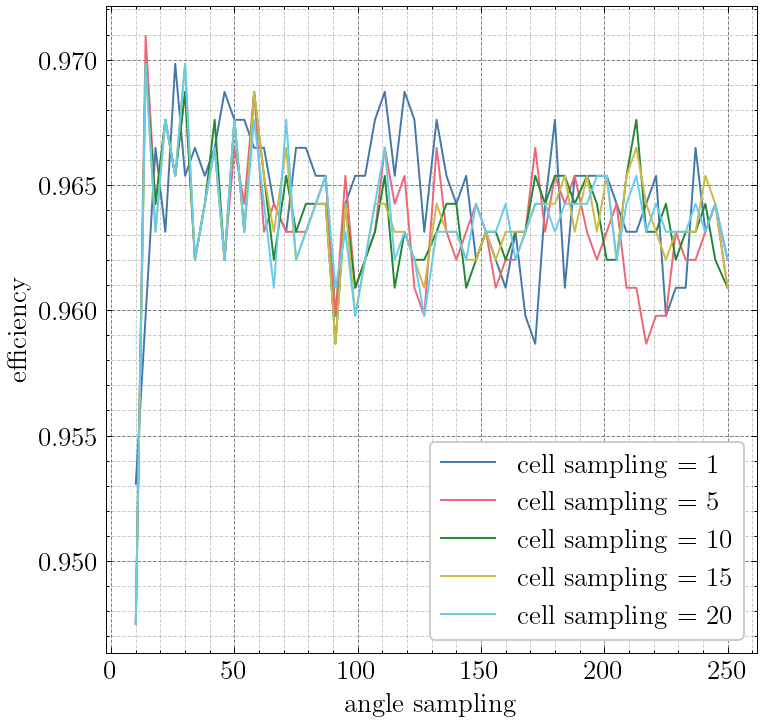

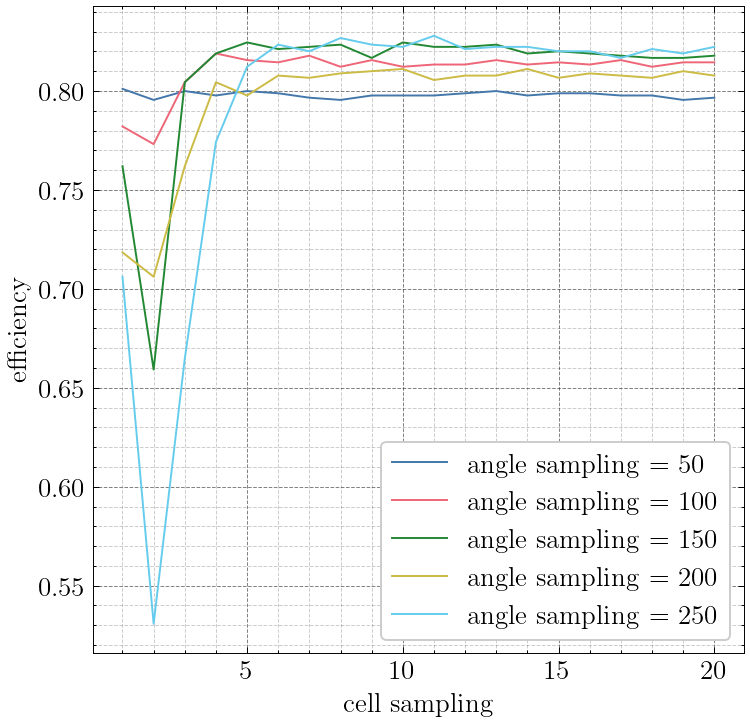

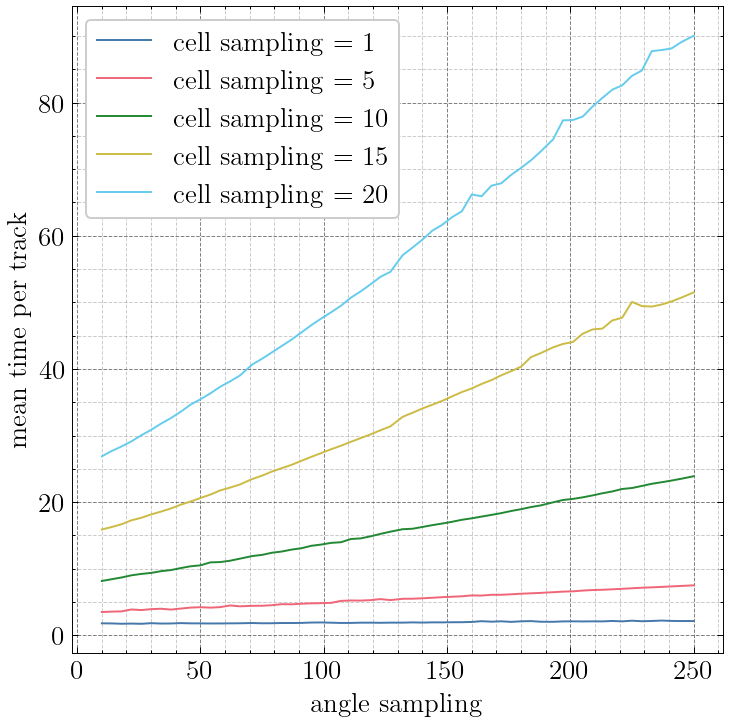

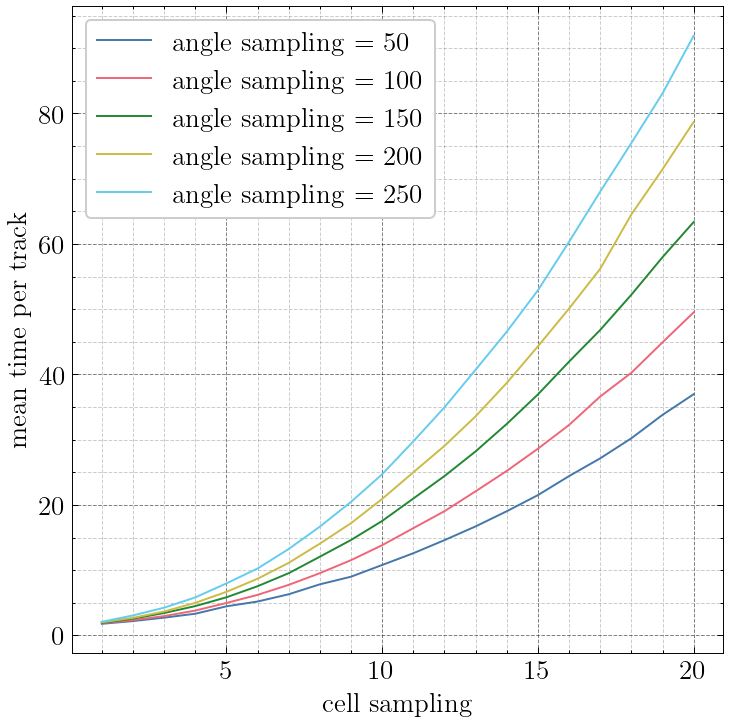

In [11]:

# fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.figure(figsize=(6, 6))
for i in range(len(cell_sampling)):
    plt.plot(for_cells_angle_sampling, ratios_for_cells[i], label = 'cell sampling = {}'.format(cell_sampling[i]))
plt.xlabel('angle sampling')
plt.ylabel('efficiency')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_ratio_for_cells2.pdf')

plt.figure(figsize=(6, 6))
for i in range(len(angle_sampling)):
    plt.plot(for_angles_cell_sampling, ratios_for_angles[i], label = 'angle sampling = {}'.format(angle_sampling[i]))
plt.xlabel('cell sampling')
plt.ylabel('efficiency')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_ratio_for_angles2.pdf')

# fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.figure(figsize=(6, 6))
for i in range(len(cell_sampling)):
    plt.plot(for_cells_angle_sampling, timings_for_cells[i], label = 'cell sampling = {}'.format(cell_sampling[i]))
plt.xlabel('angle sampling')
plt.ylabel('mean time per track')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_timing_for_cells2.pdf')

plt.figure(figsize=(6, 6))
for i in range(len(angle_sampling)):
    plt.plot(for_angles_cell_sampling, timings_for_angles[i], label = 'angle sampling = {}'.format(angle_sampling[i]))
plt.xlabel('cell sampling')
plt.ylabel('mean time per track')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../figs/hough_parameters_timing_for_angles2.pdf')


In [ ]:
# getting the reduced chi^2 distribution
#chi_squares = [track.reduced_chi2() for track in tracks if track.reduced_chi2() is not None]

# import scipy.optimize as opt 
# import scipy.special as sp
# from scipy.stats import moyal

# chi_dist, edges = np.histogram(chi_squares, bins = 100, range = [0, 50])
# scaling = np.sum(chi_dist)
# chi_dist_scaled = chi_dist / scaling
# shift = (edges[2] - edges[1])/2
# x = [edges[i] + shift for i in range(len(edges)-1)]

# def fitfun(x, params):
    # mu, sigma, lambdaa = params
    # coeff = 2*mu + lambdaa * sigma**2 - 2.*np.array(x)
    # return 0.5 * lambdaa * np.exp(0.5 * lambdaa * coeff) * sp.erfc((mu + lambdaa * sigma**2 - x)/(np.sqrt(2)*sigma))
    # return np.exp(np.power(x - mu, 2)/(4*sigma**2)) / (np.sqrt(2*np.pi) * sigma)

# def dist_fit_diff(params, x = x, chi_dist = chi_dist_scaled):
    # return np.log(np.sum((chi_dist - fitfun(x, params))**2/chi_dist))

# x0 = [0, 2, 0.1]
# result = opt.minimize(dist_fit_diff, x0)
# print(result.x)

# params = moyal.fit(chi_dist_scaled)
# print(params)

In [ ]:
# plt.figure()
# plt.title('reduced chi square, {} events'.format(len(chi_squares)))
# plt.stairs(chi_dist, edges, fill=True, label='data')
# plt.axvline(x=2 * 3.841, ymin=0.0, ymax=1.0, color='g', label = 'limit')
# xs = np.linspace(0, 50, 1000)
# plt.plot(xs, scaling * fitfun(xs, result.x), 'r--', label='fit ({:.3f}, {:.3f}, {:.3f})'.format(result.x[0], result.x[1], result.x[2]))
# plt.plot(xs, scaling * moyal.pdf(xs), 'k--', label='moyal ({:.3f}, {:.3f})'.format(params[0], params[1]))
# plt.xlabel('$\chi^2_{\mathrm{red}}$')
# plt.ylabel('counts')
# plt.legend()

